In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # vecinos más cercanos para clasificación
from sklearn.metrics import accuracy_score # métrica de evaluación
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
import numpy as np
import sys
sys.path.append('../Code')
from Plots import plt_learning_curve
df = pd.read_csv('../datasets/smokers.csv')
df = df[['triglyceride', 'Gtp', 'hemoglobin', 'serum creatinine', 'smoking']]
X = df.drop(['smoking'], axis=1)
y = df['smoking']

Estarán de acuerdo que en terminos de Exactitud hemos conseguido el mejor resultado posible (Si logran mejores valores nos avisan!)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
scaler_X = StandardScaler(with_mean=True, with_std=True)
scaler_X.fit(X_train) # entrenamos los valores quitandole la variable clase
X_train.loc[:,X_train.columns] = scaler_X.transform(X_train)
X_test.loc[:,X_test.columns] = scaler_X.transform(X_test)
model = KNeighborsClassifier(metric='euclidean', n_neighbors=69, weights='distance')
model.fit(X_train,y_train) # Entrenamos el clasificador
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.81      0.82      0.82      7400
           1       0.69      0.67      0.68      4296

    accuracy                           0.77     11696
   macro avg       0.75      0.74      0.75     11696
weighted avg       0.76      0.77      0.76     11696



Con mucho esfuerzo :) logramos un accuracy de 0.77

Modificamos el dataset, que es conocido por nosotros para hacer que una clase sea prevalente sobre la otra

<AxesSubplot:xlabel='smoking', ylabel='count'>

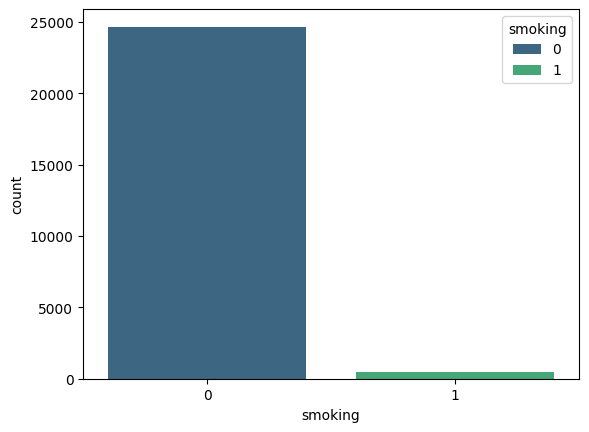

In [14]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

rus = RandomUnderSampler(sampling_strategy={1: 500}, random_state=42)
X_res, y_res = rus.fit_resample(X, y)
df_res = pd.DataFrame(pd.concat([X_res, y_res], axis=1), columns=df.columns)
sns.countplot(x='smoking', data=df_res, hue='smoking', palette='viridis')

El accuracy es excelente, pero ¿me sirve?

In [15]:
X = df_res.drop(['smoking'], axis=1)
y = df_res['smoking']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
scaler_X = StandardScaler(with_mean=True, with_std=True)
scaler_X.fit(X_train) # entrenamos los valores quitandole la variable clase
X_train.loc[:,X_train.columns] = scaler_X.transform(X_train)
X_test.loc[:,X_test.columns] = scaler_X.transform(X_test)
model = KNeighborsClassifier(metric='euclidean', n_neighbors=69, weights='distance')
model.fit(X_train,y_train) # Entrenamos el clasificador
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7400
           1       0.00      0.00      0.00       150

    accuracy                           0.98      7550
   macro avg       0.49      0.50      0.49      7550
weighted avg       0.96      0.98      0.97      7550



¿Que puedo hacer? El modelo es muy simple (KNN) y ademas lo logramos con muy pocas columnas. Respuesta: Undersample

<AxesSubplot:xlabel='smoking', ylabel='count'>

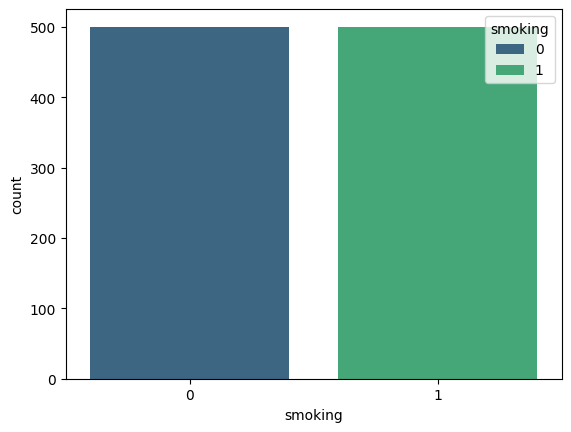

In [16]:
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_res, y_res = rus.fit_resample(X, y)
df_res = pd.DataFrame(pd.concat([X_res, y_res], axis=1), columns=df.columns)
sns.countplot(x='smoking', data=df_res, hue='smoking', palette='viridis')

Obtengo resultados comparables. Esto es cierto para tan pocos datos por la simplicidad de KNN y por las pocas columnas con la que trabajamos

In [17]:
X = df_res.drop(['smoking'], axis=1)
y = df_res['smoking']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
scaler_X = StandardScaler(with_mean=True, with_std=True)
scaler_X.fit(X_train) # entrenamos los valores quitandole la variable clase
X_train.loc[:,X_train.columns] = scaler_X.transform(X_train)
X_test.loc[:,X_test.columns] = scaler_X.transform(X_test)
model = KNeighborsClassifier(metric='euclidean', n_neighbors=69, weights='distance')
model.fit(X_train,y_train) # Entrenamos el clasificador
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.64      0.70       150
           1       0.69      0.82      0.75       150

    accuracy                           0.73       300
   macro avg       0.74      0.73      0.73       300
weighted avg       0.74      0.73      0.73       300



Las curvas de aprendizaje demuestran que no es necesario tener 40000 datos para realizar la clasificación

In [18]:
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline

#La verdad es que para hacerlo correctamente necesitamos un pipeline, pero no lo hemos visto en clase
#puntualmente aca no somos displicentes y hacemos lo correcto, mas adelante lo explicaremos
#Pongo menos vecinos por la cantidad de datos disponibles
pl = Pipeline(steps=[('scaler', StandardScaler(with_mean=True, with_std=True)), 
                     ('knn', KNeighborsClassifier(metric='euclidean', n_neighbors=10))])
#, 
skf = KFold(n_splits=10, shuffle=True, random_state=42)
train_sizes, train_scores, test_scores = learning_curve(estimator=pl,
                                                        X=X,
                                                        y=y,
                                                        scoring="accuracy", #
                                                        train_sizes=np.linspace(0.1, 1, 10),
                                                        cv=skf,n_jobs=1)


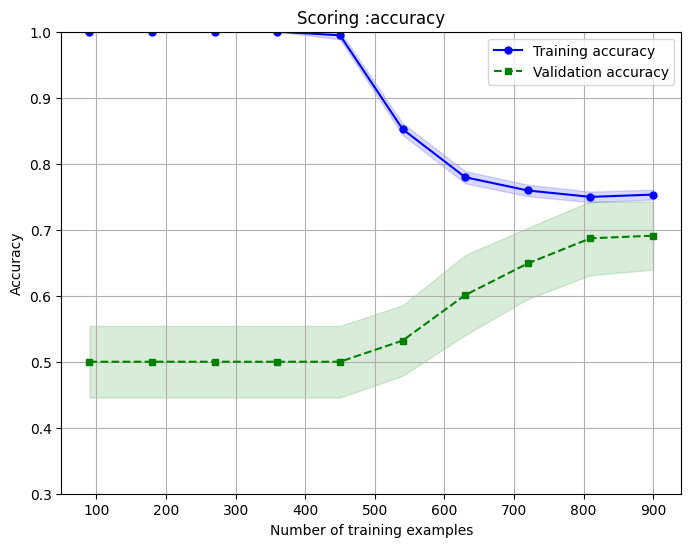

In [8]:
plt_learning_curve(train_sizes, train_scores, test_scores, "accuracy", ylims=[0.3, 1])